In [15]:
import os
import keras
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import  Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from random import shuffle
import math
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt
from keras.models import load_model
import statistics
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [30]:
PathSpectogramFolder='Spectogram'

interictalSpectograms=[]
preictalSpectograms=[]  #This array contains syntetic data, it's created to have a balance dataset and it's used for training
preictalRealSpectograms=[]  #This array containt the real preictal data, it's used for testing
filesPath=[]

patients = ["01","02","03","05","09","10","23"]
nSeizure=0
OutputPathModels = 'models/'

initial_learning_rate = 0.001

dir_name = "model_checkpoint"

In [16]:
def loadSpectogramData(indexPat):
    global interictalSpectograms
    global preictalSpectograms
    global preictalRealSpectograms
    global nSeizure
    f = open(PathSpectogramFolder+'/paz'+patients[indexPat]+'/legendAllData.txt', 'r')
    line=f.readline()
    while(not "SEIZURE" in line):
        line=f.readline()
    nSeizure=int(line.split(":")[1].strip())
    line=f.readline()
    line=f.readline()#legge il numero di spectogrammi. non lo salvo dato che non mi serve
    nSpectograms=int(line.strip())
    nFileForSeizure=math.ceil(math.ceil(nSpectograms/50)/nSeizure)
    line=f.readline()#leggo il percorso del primo file
    
    #Lettura path files Interictal
    cont=-1
    indFilePathRead=0
    while("npy" in line and indFilePathRead<nSeizure*nFileForSeizure):
        if(indFilePathRead%nFileForSeizure==0):
            interictalSpectograms.append([])
            cont=cont+1
            interictalSpectograms[cont].append(line.split(' ')[2].rstrip())#.rstrip() remove \n
            indFilePathRead=indFilePathRead+1
        else:
            if(len(line.split(' '))>=3):
                interictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
            
        line=f.readline()
    line=f.readline()#leggo PREICTAL
    line=f.readline()#leggo n° spectogram
    line=f.readline()#leggo n°seizure(SEIZURE X)

    #Lettura path files Preictal
    cont=-1
    indFilePathRead=0   
    #while(line and indFilePathRead<nSeizure*nFileForSeizure):    
    while(line.strip()!=""):
        if("SEIZURE" in line):
            line=f.readline()#ho letto n°seizure(SEIZURE X) perciò scorro in avanti
            if(len(line.split(' '))>=3):
                preictalSpectograms.append([])
                cont=cont+1
                preictalSpectograms[cont].append(line.split(' ')[2].rstrip())
                indFilePathRead=indFilePathRead+1
        else:
            if(len(line.split(' '))>=3):
                preictalSpectograms[cont].append(line.split(' ')[2].rstrip())
            indFilePathRead=indFilePathRead+1
            
        line=f.readline()
        
    line=f.readline()#leggo REAL_PREICTAL
    line=f.readline()#leggo n° spectogram
    line=f.readline()#leggo n°seizure(SEIZURE X)

    #Lettura path files Real Preictal
    cont=-1
    while(line):
        if("SEIZURE" in line):
            line=f.readline()#ho letto n°seizure(SEIZURE X) perciò scorro in avanti
            preictalRealSpectograms.append([])
            cont=cont+1
            preictalRealSpectograms[cont].append(line.split(' ')[2].rstrip())
        else:
            preictalRealSpectograms[cont].append(line.split(' ')[2].rstrip())
            
        line=f.readline()
    f.close()

In [17]:
def createModel1():

    model = Sequential()

    # C1
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(22, 59, 114)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # C2
    model.add(Conv2D(32, (2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # C3
    model.add(Conv2D(64, (2, 2), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    return model

In [31]:
def createModel2():

    model = Sequential()

    # C1
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(22, 59, 114)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # C2
    model.add(Conv2D(32, (2, 2), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    # C3
    model.add(Conv2D(64, (2, 2), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    return model

In [19]:
def getFilesPathWithoutSeizure(indexSeizure):
    for i in range(0, nSeizure):
        if(i!=indexSeizure):
            filesPath.extend(interictalSpectograms[i])
            filesPath.extend(preictalSpectograms[i])
    shuffle(filesPath)
    return filesPath

In [20]:
def generate_arrays_for_training(paths, start=0, end=100):
    while True:
        from_=int(len(paths)/100*start)
        to_=int(len(paths)/100*end)
        for i in range(from_, int(to_)):
            f=paths[i]
            x = np.load(PathSpectogramFolder+f)
            x=np.array([x])
            x=x.swapaxes(0,1)
            x=x[0]
            if('P' in f):
                y = np.repeat([[0,1]], x.shape[0], axis=0)
            else:
                y = np.repeat([[1,0]], x.shape[0], axis=0)
            yield(x,y)

In [21]:
def generate_arrays_for_predict(indexPat, paths, start=0, end=100):
    while True:
        f = open(PathSpectogramFolder+'/paz'+patients[indexPat]+'/legendAllData.txt', 'r')
        line=f.readline()
        while(not "SEIZURE" in line):
            line=f.readline()
        nSeizure=int(line.split(":")[1].strip())
        from_=int(len(paths)/100*start)
        to_=int(len(paths)/100*end)
        for i in range(from_, int(to_)):
            f=paths[i]
            x = np.load(PathSpectogramFolder+f)
            x=np.array([x])
            x=x.swapaxes(0,1)
            x=x[0]
            yield(x)

In [22]:
def init():
    interictalSpectograms=[]
    preictalSpectograms=[]  #This array contains syntetic data, it's created to have a balance dataset and it's used for training
    preictalRealSpectograms=[]  #This array containt the real preictal data, it's used for testing
    filesPath=[]
    nSeizure=0

    print("START")
    if not os.path.exists(OutputPathModels):
        os.makedirs(OutputPathModels)
    print("Parameters loaded")

    for indexPat in range(0, len(patients)):
        loadSpectogramData(indexPat) 
        filesPath = getFilesPathWithoutSeizure(indexPat)


In [23]:
def plot_model(train_loss, val_loss, train_acc, val_acc):
    
    epochs = range(len(train_loss))

    plt.figure()
    plt.plot(epochs, train_loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.figure()
    plt.plot(epochs, train_acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.show()

In [32]:
def evaluation_model(model):

    for indexPat in range(0, len(patients)):
        
        if not os.path.exists(OutputPathModels+"ModelPat"+patients[indexPat]+"/"):
            os.makedirs(OutputPathModels+"ModelPat"+patients[indexPat]+"/")

        loadSpectogramData(indexPat)

        sensResults = []
        FPRResults = []

        result='Patient '+patients[indexPat]+'\n'     
        result='Out Seizure, True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR \n'
        for i in range(0, nSeizure):

            filesPath=interictalSpectograms[i]
            interPrediction=model.predict(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath), verbose=0)
            filesPath=preictalRealSpectograms[i]
            preictPrediction=model.predict(generate_arrays_for_predict(indexPat, filesPath), max_queue_size=4, steps=len(filesPath), verbose = 0)
            
            #to plot the model
            #plot_model(model, to_file="CNNModel", show_shapes=True, show_layer_names=True)
            
            if not os.path.exists(OutputPathModels+"OutputTest"+"/"):
                os.makedirs(OutputPathModels+"OutputTest"+"/")
            np.savetxt(OutputPathModels+"OutputTest"+"/"+"Int_"+patients[indexPat]+"_"+str(i+1)+".csv", interPrediction, delimiter=",")
            np.savetxt(OutputPathModels+"OutputTest"+"/"+"Pre_"+patients[indexPat]+"_"+str(i+1)+".csv", preictPrediction, delimiter=",")
            
            secondsInterictalInTest=len(interictalSpectograms[i])*50*30#50 spectograms for file, 30 seconds for each spectogram
            acc=0#accumulator
            fp=0
            tp=0
            fn=0
            lastTenResult=list()
            
            for el in interPrediction:
                if(el[1]>0.5):
                    acc=acc+1
                    lastTenResult.append(1)
                else:
                    lastTenResult.append(0)
                if(len(lastTenResult)>10):
                    acc=acc-lastTenResult.pop(0)
                if(acc>=4):
                  fp=fp+1
                  lastTenResult=list()
                  acc=0
            
            lastTenResult=list()
            for el in preictPrediction:
                if(el[1]>0.5):
                    acc=acc+1
                    lastTenResult.append(1)
                else:
                    lastTenResult.append(0)
                if(len(lastTenResult)>10):
                    acc=acc-lastTenResult.pop(0)
                if(acc>=4):
                  tp=tp+1 
                else:
                    if(len(lastTenResult)==10):
                       fn=fn+1 
                       
            if (tp+fn)!=0:
                sensitivity=tp/(tp+fn)
            else:
                sensitivity=0
            FPR=fp/(secondsInterictalInTest/(60*60))
            
            result=result+str(i+1)+','+str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','
            result=result+str(sensitivity)+','+str(FPR)+'\n'
            #print('True Positive, False Positive, False negative, Second of Inter in Test, Sensitivity, FPR')
            #print(str(tp)+','+str(fp)+','+str(fn)+','+str(secondsInterictalInTest)+','+str(sensitivity)+','+str(FPR))
        
            sensResults.append(sensitivity)
            FPRResults.append(FPR)
  
                    
        sdSENS=round(statistics.stdev(sensResults)*100,2)
        avSENS=round(statistics.mean(sensResults)*100,2)
        
        sdFPR=round(statistics.stdev(FPRResults)*100,2)
        avFPR=round(statistics.mean(FPRResults)*100,2)

        print('Patient '+patients[indexPat]+"  & "+str(avSENS)+" +- "+str(sdSENS)+"   & "+str(avFPR)+" +- "+str(sdFPR))

First Model

START
Parameters loaded
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 22, 59, 16)        16432     
                                                                 
 batch_normalization_36 (Bat  (None, 22, 59, 16)       64        
 chNormalization)                                                
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 11, 29, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 11, 29, 32)        2080      
                                                                 
 batch_normalization_37 (Bat  (None, 11, 29, 32)       128       
 chNormalization)                                                
                             

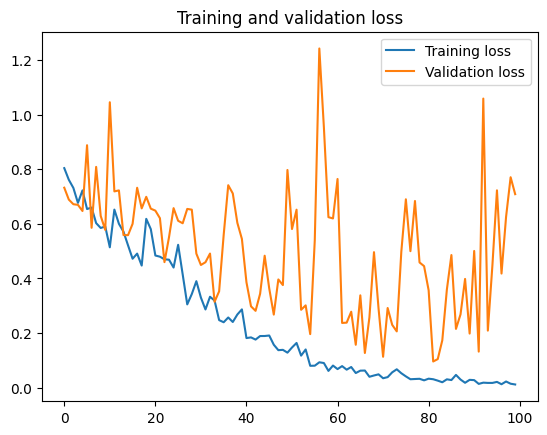

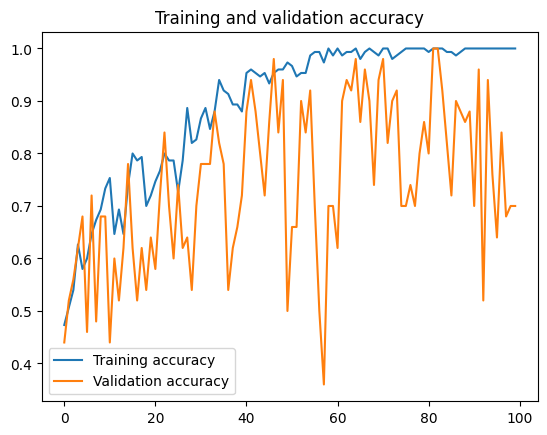

Training end
Evaluating Model


In [78]:
init()

if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'Model1.h5')

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

model = createModel1()

optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='sen')])
    
model.summary()

history = model.fit(generate_arrays_for_training(filesPath, end=80),
                        validation_data=generate_arrays_for_training(filesPath, start=20),
                        steps_per_epoch=150,
                        validation_steps=50,
                        epochs=100, max_queue_size=2, shuffle=True, callbacks=[callbacks_list])

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Creates a HDF5 file 
model.save("ModelOutSeizure3.h5")
print("Model saved")
        
plot_model(train_loss, val_loss, train_acc, val_acc)

print('Training end')

print('Evaluating Model')


In [33]:
init()
model = load_model('model_checkpoint/Model1.h5')
print('Evaluating Model')
evaluation_model(model)

START
Parameters loaded
Evaluating Model


ResourceExhaustedError: Graph execution error:

MemoryError: Unable to allocate 56.4 MiB for an array with shape (1, 50, 22, 59, 114) and data type float64
Traceback (most recent call last):

  File "C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\ops\script_ops.py", line 267, in __call__
    ret = func(*args)

  File "C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\autograph\impl\api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tensorflow\python\data\ops\from_generator_op.py", line 198, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\data_adapter.py", line 902, in wrapped_generator
    for data in generator_fn():

  File "C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2336\1835626746.py", line 13, in generate_arrays_for_predict
    x=np.array([x])

numpy.core._exceptions._ArrayMemoryError: Unable to allocate 56.4 MiB for an array with shape (1, 50, 22, 59, 114) and data type float64


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_32249]

Model With Dropout

In [15]:
init()

if not os.path.exists(dir_name):
        os.makedirs(dir_name)
save_path = os.path.join(dir_name, 'Model2.h5')

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
    filepath=save_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True)
]

model = createModel2()

optimizer = tf.keras.optimizers.SGD(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Recall(name='sen')])
    
model.summary()

history = model.fit(generate_arrays_for_training(filesPath, end=75), #end=75),#It take the first 75%
                        validation_data=generate_arrays_for_training(filesPath, start=75),#start=75), #It take the last 25%
                        #steps_per_epoch=10000, epochs=10)
                        steps_per_epoch=150, 
                        validation_steps=50,
                        epochs=100, max_queue_size=2, shuffle=True, callbacks=[callbacks_list])# 100 epochs è meglio #aggiungere criterio di stop in base accuratezza

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
        
plot_model(train_loss, val_loss, train_acc, val_acc)

print('Training end')

evaluation_model(model)

START
Parameters loaded
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 22, 59, 16)        16432     
                                                                 
 batch_normalization (BatchN  (None, 22, 59, 16)       64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 11, 29, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 11, 29, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 29, 32)        2080      
                                                                 
 batch_normalization_1 (Batc  (N